In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, filters
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
# Function to read image saved on google drive
def readImage(number, jpg = False):
    if jpg == True:
        path = "images/" + str(number) + ".jpg"
    else:
        path = "images/" + str(number) + ".tif"
    img = cv.imread(path)
    return img[:,:,::-1]

# Function to display image using matplotlib
def displayImage(a, title1 = "Img"):
    plt.imshow(a, cmap='gray', vmin=0, vmax=255), plt.title(title1)
    plt.show()

In [3]:
# Area-based cleaning of image
def clean(img, areaThreshold = 25):
    # Find all connected components
    output = cv.connectedComponentsWithStats(np.uint8(img), 4, cv.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]

    # output image
    cleaned = np.copy(np.uint8(img))
    # if area of any connected component is less than area threshold, remove that component
    for i in range(cleaned.shape[0]):
        for j in range(cleaned.shape[1]):
            if stats[labels[i][j], cv.CC_STAT_AREA] < areaThreshold:
                cleaned[i][j] = 0
    return cleaned

In [4]:
def removeDisk(img, n, binThresh = 11, blackHat = True):
    kernel = diskKernel(n)
    if blackHat is True:
        blackhat = cv.morphologyEx(img, cv.MORPH_BLACKHAT, kernel)
        displayImage(blackhat, "Blackhat " + str(n))
        ret,thresh = cv.threshold(blackhat, binThresh, 255,cv.THRESH_BINARY)
    else:
        tophat = cv.morphologyEx(img, cv.MORPH_TOPHAT, kernel)
        displayImage(tophat, "Tophat " + str(n))
        ret,thresh = cv.threshold(tophat, binThresh, 255,cv.THRESH_BINARY)
    displayImage(thresh, "Thresh " + str(n))
    return thresh

In [5]:
# Extract green channel from image
def extractChannel(img, channel = 'g'):
    # RGB instead of BGR bcooz we flipped it earlier while reading image
    r, g, b = cv.split(img)
    if channel == 'g':
        return g
    if channel == 'r':
        return r
    return b

In [6]:
def diskKernel(n):
    return cv.getStructuringElement(cv.MORPH_ELLIPSE,(2*n - 1 , 2*n - 1))

In [7]:
# Function to apply clahe on input image
def applyCLAHE(img):
    # hyper-parameters in clahe
    limit=3; grid=(7,7)
    clahe = cv.createCLAHE(clipLimit=limit, tileGridSize=grid)
    # output image
    img = clahe.apply(img)
    displayImage(img, "CLAHE")
    return img

### Removing optic disk

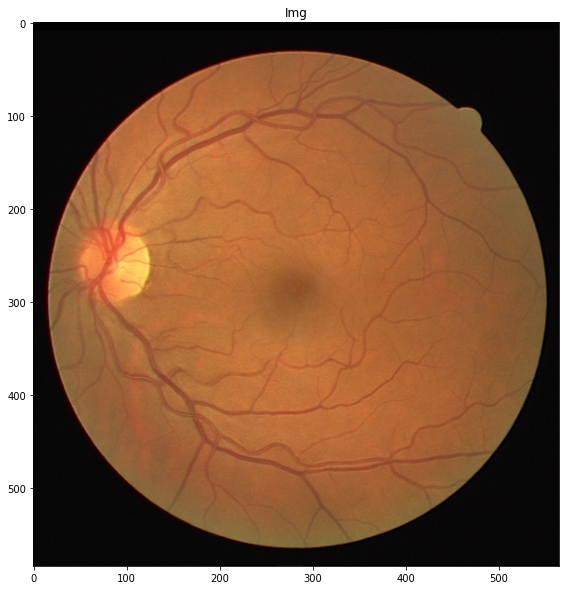

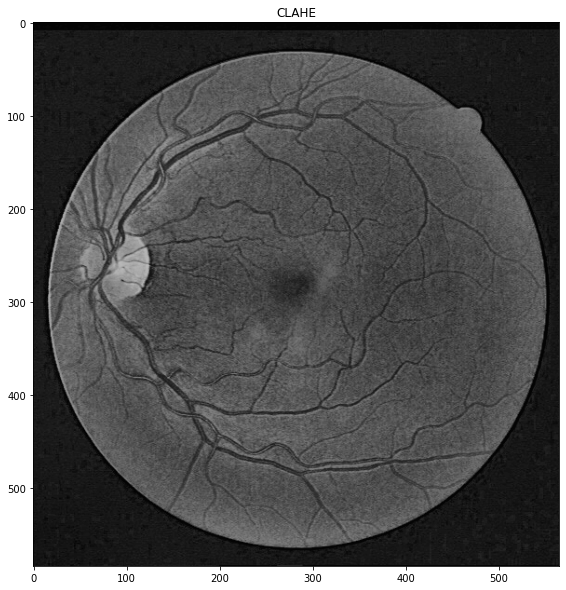

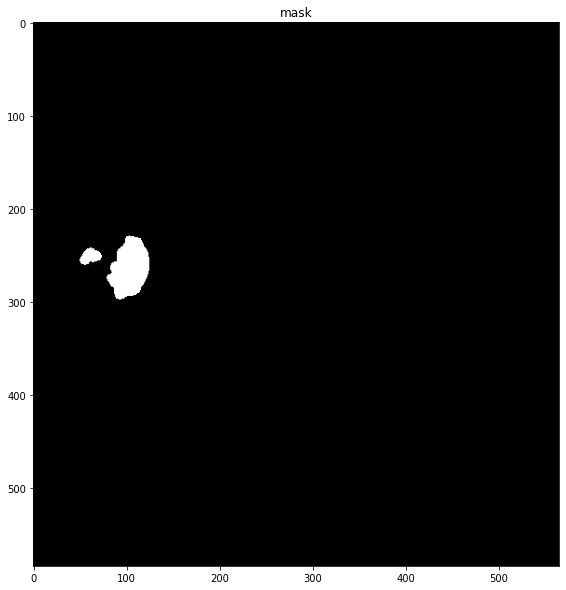

In [8]:
img = readImage(1)
displayImage(img)
b = extractChannel(img, 'b')
cl = applyCLAHE(b)
filtered = cv.medianBlur(cl,5)
opening = cv.morphologyEx(filtered, cv.MORPH_OPEN, diskKernel(5))
ret,mask = cv.threshold(opening, 127, 255,cv.THRESH_BINARY)
displayImage(mask, 'mask')

## Vessel Map

### Approach 1

Disk not removed

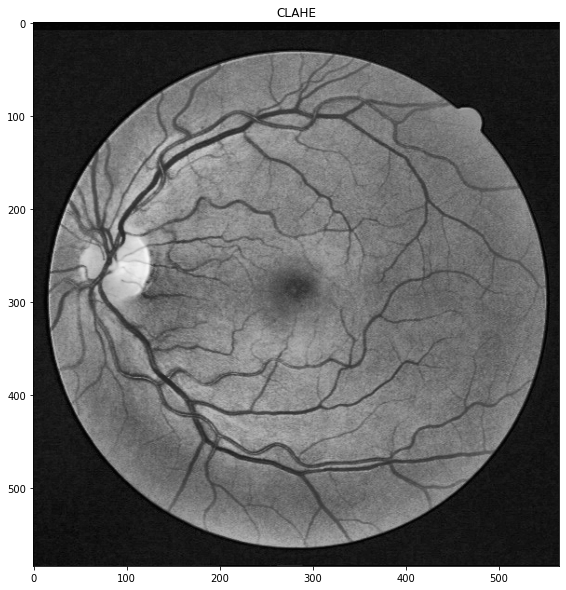

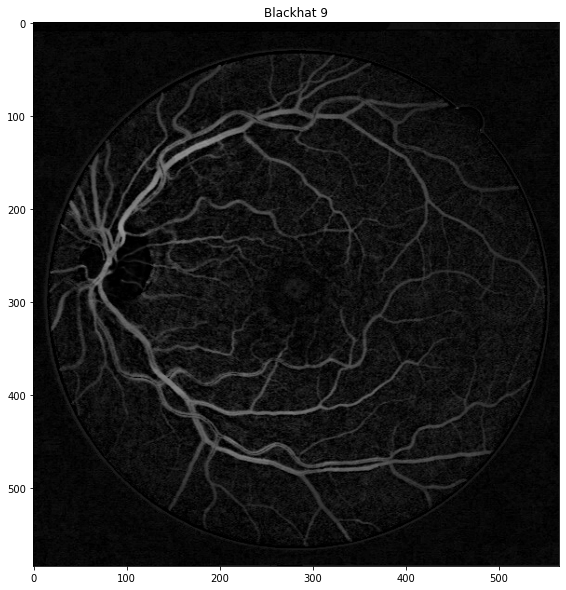

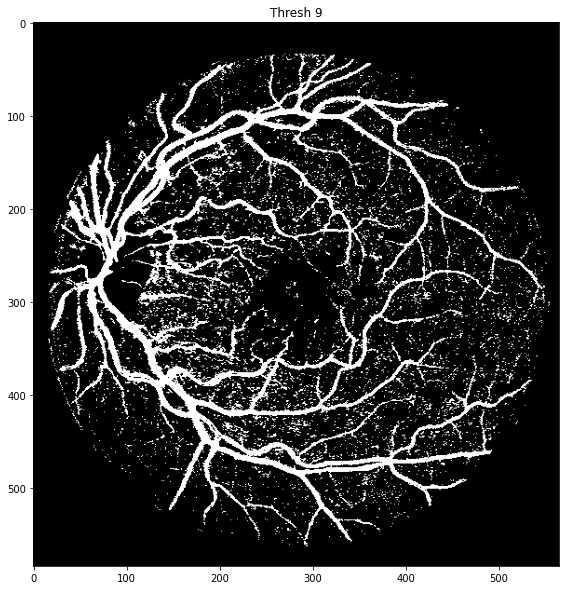

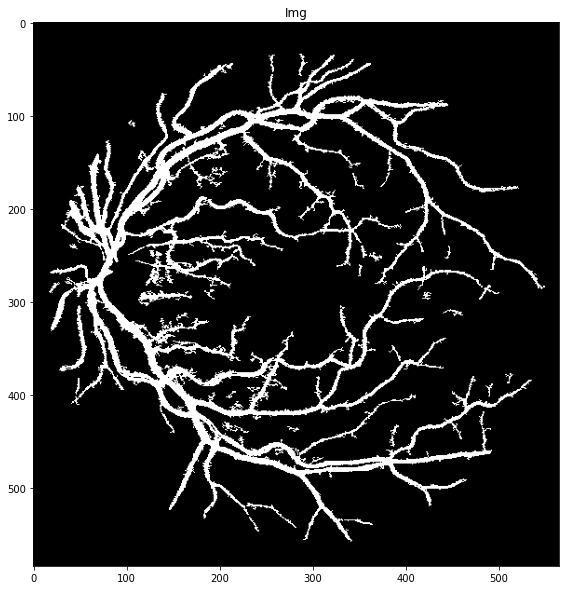

In [97]:
g = extractChannel(img, 'g')
cl = applyCLAHE(g)
g_filter = cv.GaussianBlur(cl,(1, 1),0)
thresh = removeDisk(g_filter, 9, 30)
arCleaned1 = clean(thresh, 25)
displayImage(arCleaned1)

### Approach 2

Disk removed

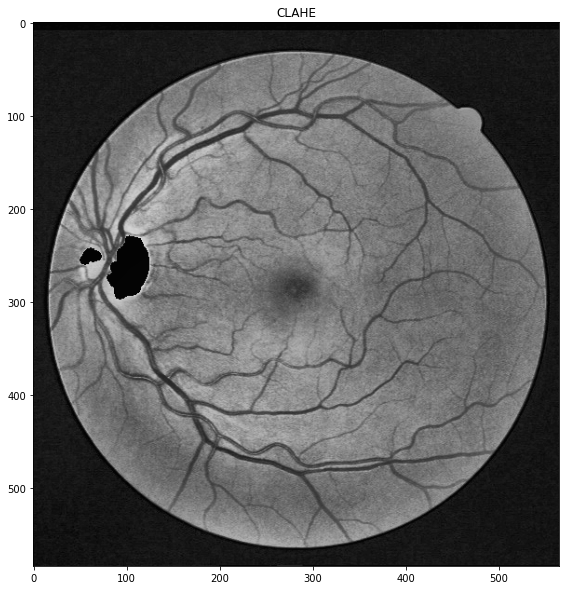

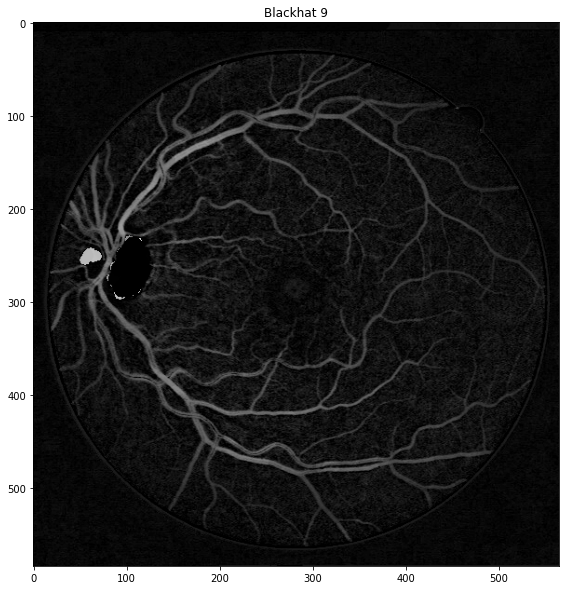

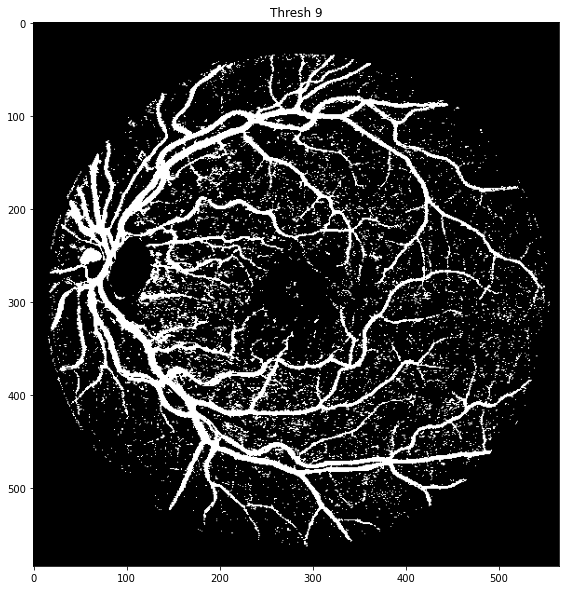

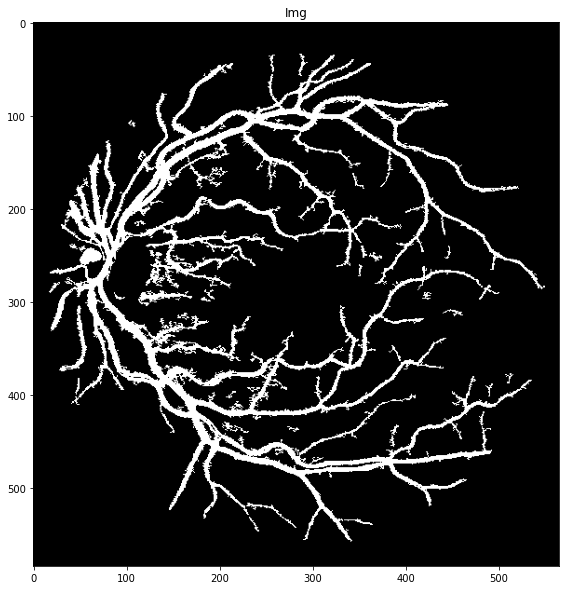

In [96]:
g = extractChannel(img, 'g')
for i in range(g.shape[0]):
    for j in range(g.shape[1]):
        if mask[i][j] == 255:
            g[i][j] = 0
cl = applyCLAHE(g)
g_filter = cv.GaussianBlur(cl,(1, 1),0)
thresh = removeDisk(g_filter, 9, 30)
arCleaned2 = clean(thresh, 25)
displayImage(arCleaned2)

### Hole filling

Since approach 1 is better than approach 2, we move forward with "arCleaned1"

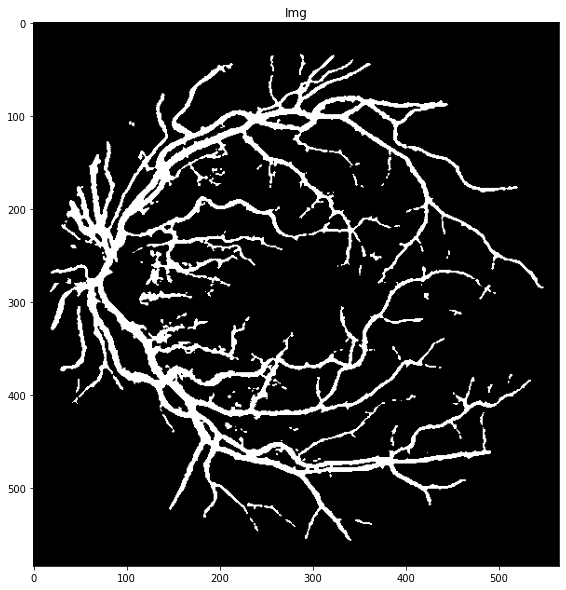

In [95]:
med = cv.medianBlur(arCleaned1, 3)
displayImage(med)

### Diameters

In [88]:
# ellipse kernel
def diskKernel2(size):
      return cv.getStructuringElement(cv.MORPH_ELLIPSE, (size, size))

In [89]:
# set difference 
def difference(image1 , image2):
    newimg = np.zeros(image1.shape , np.uint8)
    newimg[(image1 == 255) & (image2 == 0)] = 255
    return newimg

In [90]:
# set intersection
def intersect(image1 , image2):
    newimg = np.zeros(image1.shape , np.uint8)
    newimg[(image1 == 255) & (image2 == 255)] = 255
    return newimg 

In [91]:
def find_thickest(input_img):
    diameter = 2
    output_img = cv.erode(input_img,diskKernel2(diameter),iterations = 1)
    while(np.any(output_img > 0)):
        diameter = diameter + 1
        output_img = cv.erode(input_img,diskKernel2(diameter),iterations = 1)
    return diameter - 1

In [92]:
def find_thinnest(input_img):
    diameter = 1
    output_img = np.zeros(input_img.shape , dtype = np.uint8)
    while(not np.any(output_img > 0)):
        diameter = diameter + 1
        erode = cv.erode(input_img,diskKernel2(diameter),iterations = 1)
        dilat = cv.dilate(erode,diskKernel2(diameter),iterations = 1)
        output_img = difference(input_img , intersect(dilat , input_img))
    return diameter-1

In [93]:
print("diameter of thickest vessel :" + str(find_thickest(arCleaned1)))
print("diameter of thinnest vessel :" + str(find_thinnest(arCleaned1)))

diameter of thickest vessel :13
diameter of thinnest vessel :1
